In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import convolve2d, savgol_filter
from PIL import Image
from pointing2d_backfiltlib import filterImage, walkDir, norm_gaus2d_ary
from pointing2d_lib import load_points_from_file, points_to_roi
import os
import pointing2d_fit as fit
import csv



# GET FILES


In [12]:
folder = "D:\\Bunker C\\2022\\Dec 05\\Pointing Lanex\\Run005\\HE\\"
#folder = "D:\\Bunker C\\Lanex\\E_Spec_test_data\\042023_2a\\synced_with_spectrometer\\"

#files = walkDir(folder)

saving = True

exportDir = "{}\\EXPORTED".format(folder)  # name the subdirectory to export to
if saving and not os.path.exists(exportDir):  # check if it exists
    os.mkdir(exportDir)  # create it if not

#GoodShot = files[8]
#Background = files[-1]

points_file =  f"{folder}points_data.txt"
analyse = {k: points_to_roi(v,w=1288,h=964,x_pad=150,y_pad=100) for k, v in load_points_from_file(points_file).items() if len(v) > 0} #is not None}

print(f"found {len(analyse)} rois")

Background = "D:\\Bunker C\\2022\\Dec 05\\Pointing Lanex\\Run005\\HE\\Run005-12052022163736-1.tiff"


found 87 rois


# Load Calibrations

In [13]:

"""
CALIBRATION
"""
def ratio_of_quads(x,a,b,c,d,e):
    n = (a*x*x)+(b*x) + c
    d = (x*x) + (d*x) + e 
    y = n/d
    return(y)

# espec calibration lookup
# { 'DAY' : [a,b,c,d,e] }
espec_coeffs = {
    '22-12-05' : [19.5487,58230.3,7.48844e7,-3014.01,2.38075e6],# [11.5, 24170, 32519703, -2880, 2150460], ## ???? im doubtful of this calibration
    '23-03-23' :[16.82203932056203,44381.734282360354,50860414.825793914,-2919.0964588725824,2204294.821475454],
    '23-03-24' :[16.82203932056203,44381.734282360354,50860414.825793914,-2919.0964588725824,2204294.821475454],
    '23-04-20' :[9.2080820556058758,35563.53137486182,4.48789354385e7,-2933.2162484668197,2281787.5593547565],
    '23-04-26' :[9.280269716645035,36492.34932605621,48405689.11574387,-3352.4915825373205,2961512.5164166116],
    '23-04-27' :[9.280351087922435,26752.558352428678,25734721.443078351683,-2345.4430,1453419.190032153],
    '23-04-28' :[9.280351087922435,26752.558352428678,25734721.443078351683,-2345.4430,1453419.190032153]
}

plotcalibs = False #True
if plotcalibs:
    X = np.linspace(1,1000,1000)

    fig,ax = plt.subplots(1,1)
    for day in espec_coeffs.keys():
        a,b,c,d,e = espec_coeffs[day]
        ax.plot(X,ratio_of_quads(X,a,b,c,d,e),label=day)
    ax.grid("both","both")
    ax.legend(loc='best')

    ax.set_xlabel("Pixel")
    ax.set_ylabel("Energy")
    ax.set_title(f"Espec Calibrations")
    fig.show()


# Test Random Suite

In [14]:
n_cols = 3
n_rows = 1

import random
import time

random.seed(time.time())
selection = random.choices(list(analyse.items()),k=n_rows*n_cols)
print(selection)


[('D:/Bunker C/2022/Dec 05/Pointing Lanex/Run005/HE/Run005-12052022164333-358.tiff', [[111, 254], [861, 654]]), ('D:/Bunker C/2022/Dec 05/Pointing Lanex/Run005/HE/Run005-12052022164201-266.tiff', [[213, 432], [963, 832]]), ('D:/Bunker C/2022/Dec 05/Pointing Lanex/Run005/HE/Run005-12052022164133-238.tiff', [[74, 299], [824, 699]])]


[1, 0.5]
rows 0 and 1, col 0


c:\Users\Willow\anaconda3\envs\LanexPointingLib\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


rows 0 and 1, col 1
ROI goes close to the right edge of the image
rows 0 and 1, col 2


IndexError: index 2 is out of bounds for axis 0 with size 2

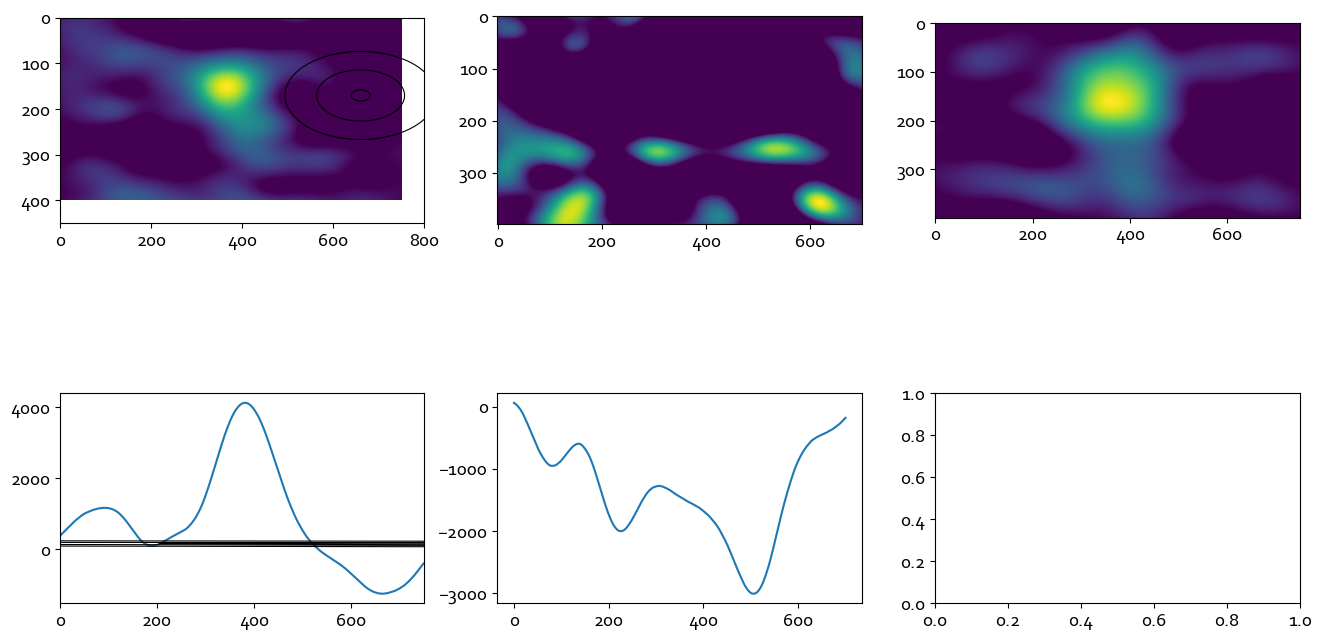

In [56]:
make_back = True
plotfit = False

x_fils = [3,5,53,5,3] # [3,5,3]
kernel = norm_gaus2d_ary(37, 3, 57, 3)

hr = [1 if i%2==0 else 0.5 for i in range(n_rows*2)]
print(hr)
fig,ax = plt.subplots(n_rows*2,n_cols,figsize=(16,9),height_ratios=hr)
for i, [im,crop] in enumerate(selection):
    j = int(np.floor(i/n_cols)%n_rows * 2)
    k = int(i%n_cols)
    print(f"rows {j} and {j+1}, col {k}")


    full = np.array(Image.open(im))
    full_back = np.array(Image.open(Background))

    for f in x_fils:  # filter xrays
        full = filterImage(full, f)
        full_back = filterImage(full_back, f)

    w,h = full.shape

    padding = 50

    flag_l = flag_r = False
    if crop[1][0] + padding > w:
        print("ROI goes close to the right edge of the image")
        flag_r = True
    if crop[1][1] + padding > h:
        print("ROI goes close to the bottom edge of the image")
        flag_l = True
    
    pad_r = min(crop[1][0] + padding, w)
    pad_l = min(crop[1][1] + padding, h)

    pad_back = full_back[crop[0][1]:pad_l,crop[0][0]:pad_r]
    pad_sig = full[crop[0][1]:pad_l,crop[0][0]:pad_r]

    smothed_shot = convolve2d(pad_sig, kernel, boundary='wrap', mode='same')
    smothed_back = convolve2d(pad_back, kernel, boundary='wrap', mode='same')

    sub = np.subtract(smothed_shot, smothed_back)
    sub = sub - sub.min()


    if plotfit:
        fmodel = fit.setup_double_2d_gauss_model()
        y_len,x_len = sub.shape
        x = np.linspace(0,x_len,x_len)
        y = np.linspace(0,y_len,y_len)
        x2, y2 = np.meshgrid(x, y)

        result = fit.fit_double_gauss2d_lm(x2, y2, sub, fmodel)
        fitted = fmodel.func(x2, y2, **result.best_values)

    if make_back:
        win_len = 31
        ord = 3
        v_slice = savgol_filter(np.mean(sub[:,-padding:-1],1),win_len,ord)
        sub = sub - v_slice[:,np.newaxis]   
    sub = sub[:-padding,:-padding]

    ax[j,k].imshow(sub, vmin = 0, vmax = sub.max())

    if plotfit:
        ax[i,j].contour(x,
                        y,
                        fitted,
                        2,
                        colors='black',
                        extent= (0,w,0,h),#(e_x[0],e_x[-1],0,sub.shape[1]),
                        linewidths=0.8)

    #ax[j,k].axvline(len(sub[0])-padding)

    ssum = sub.sum(0)
    ax[j+1,k].plot(ssum)




# read and plot csv files





84
D:\Bunker C\2022\Dec 05\Pointing Lanex\Run005\HE\/EXPORTED\Run005-12052022164022-167_lineout.csv
D:\Bunker C\2022\Dec 05\Pointing Lanex\Run005\HE\/EXPORTED\Run005-12052022164136-241_lineout.csv
D:\Bunker C\2022\Dec 05\Pointing Lanex\Run005\HE\/EXPORTED\Run005-12052022164139-244_lineout.csv
D:\Bunker C\2022\Dec 05\Pointing Lanex\Run005\HE\/EXPORTED\Run005-12052022164141-246_lineout.csv
D:\Bunker C\2022\Dec 05\Pointing Lanex\Run005\HE\/EXPORTED\Run005-12052022164237-302_lineout.csv
D:\Bunker C\2022\Dec 05\Pointing Lanex\Run005\HE\/EXPORTED\Run005-12052022164249-314_lineout.csv
84


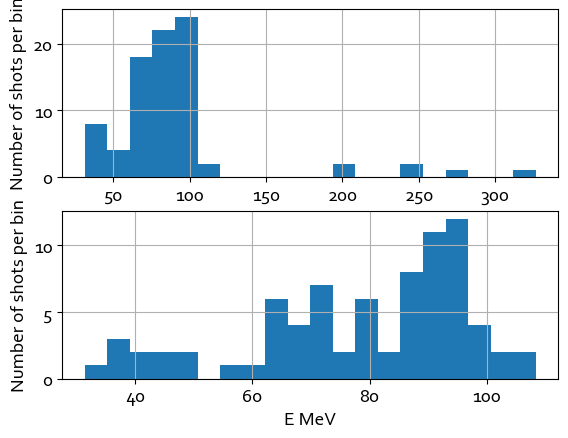

In [53]:
csv_folder = f"{folder}/EXPORTED"
peaks = []
low_peaks = []
csvs = walkDir(csv_folder,select_strings=['.csv'],ignore_strings=[])
print(len(csvs))
for file in csvs:
    with open(file) as f:
        e_x = []
        q_x = []
        skiplines = 1
        i=0
        for line in f.readlines():
            if i < skiplines: pass
            else:
                try:
                    e, q = line.split(",")
                    e_x.append(float(e))
                    q_x.append(float(q))
                except:
                    if line == "\n": # saved some files with alternating empty lines
                        pass
                    else:
                        print(line)
                        raise ValueError
            i+=1

        peak = e_x[np.argmax(q_x)]
        if peak > 160:
            print(file)
            peaks.append(peak)
        else:
            peaks.append(peak)
            low_peaks.append(peak)
print(len(peaks))
fig,ax = plt.subplots(2,1)
ax[0].hist(peaks,20)
ax[1].hist(low_peaks,20)

for a in ax:
    a.set_xlabel("E MeV")

    a.set_ylabel("Number of shots per bin")

    a.grid('both','both')
